# Import and Config

In [ ]:
# imports
from collections import Counter
import math
import os
import re

from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
from metapub import PubMedFetcher
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import pandas as pd
from PIL import Image
from wordcloud import WordCloud
from yellowbrick.cluster import KElbowVisualizer

# config
os.environ["NCBI_API_KEY"] = "14d426f38b914667658f35d09a714ad47508"
nltk.download('stopwords')
stopwords = stopwords.words('english')
fetch = PubMedFetcher()


# Fetch Articles from NCBI

In [ ]:
# get the first 1000 pmids matching "telemedicine" keyword search
pmids = fetch.pmids_for_query('telemedicine covid-19', retmax=1000)

# get abstract for each article:
abstracts = {}
titles = {}
for pmid in pmids:
    article = fetch.article_by_pmid(pmid)
    titles[pmid] = article.title
    abstracts[pmid] = article.abstract

# Define Pre-Processing Functions

In [ ]:
tokenizer = re.compile('\w+|[^\s\w]+')
def tokenize(text):
  return tokenizer.findall(text.lower())

In [ ]:
# TFIDF := term frequency inverse document frequency
# This NLP measure scales term frequency against frequency of appearance in
# documents across entire corpus
def tfidf(data, pmid):
  tfidf = {}
  pmid_data = data[data['PMID']==pmid]
  all_words = pmid_data.iloc[0,4]
  all_u_words = pmid_data.iloc[0,5]
  N = len(data)
  seq = data['u_tokens']
  dict_df = Counter(x for xs in seq for x in set(xs))  
  dict_df = dict(dict_df)
  for i in all_u_words:
      tf = all_words.count(i)
      df = dict_df[i]
      tfidf[i] = tf*math.log(N/df)
  return tfidf

def provide_features(data):
    data['tfidf'] = data.PMID.apply(lambda x: tfidf(data,x))
    return data

# Pre-Processing

In [ ]:
df_a = pd.DataFrame(abstracts.items(), columns = ['PMID','Abstract'])
df_t = pd.DataFrame(titles.items(), columns = ['PMID','Title'])
df = pd.merge(df_t, df_a, on = 'PMID')

In [ ]:
corpus_df = pd.read_excel("Bibliometrix-Export-File-telemedicine-trade_journal.xlsx", usecols = ['AB','TI'])
corpus_df = corpus_df.reset_index()
corpus_df = corpus_df.dropna().rename({'index':'PMID','TI':'Title','AB':'Abstract'},axis=1)

df = df.append(corpus_df,ignore_index = True)

In [ ]:
df['text_body'] = df['Title'] + ' '  + df['Abstract']
df['tokens'] = df['text_body'].apply(lambda x: tokenize(str(x)))
df['u_tokens'] = df['tokens'].apply(lambda x: list(set(x)))

df = df[df['Abstract']!='None']
df =df.dropna()

df = provide_features(df)

In [ ]:
df

In [ ]:
features = df['tfidf'].to_list()
features = pd.DataFrame(features)
features = features.fillna(0)
features['PM ID'] = list(df['PMID'])
k_features = features.drop(['PM ID'],axis=1).to_numpy()

# Clustering Analysis

## Parameter Selection

KElbowVisualizer provides a graphical approach to choosing the clusering parameter for the downstream KModes analysis. It entails making a tradeoff between processing time and coarse clustering performance.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f2913d1cb70>,
                 k=None, metric=None, model=None, timings=True)

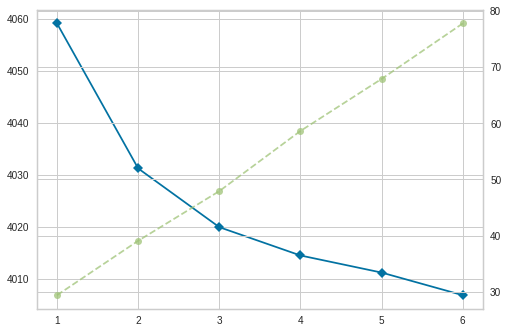

In [ ]:
model = KModes()
visualizer = KElbowVisualizer(model, k=(1,7))
visualizer.fit(k_features)

## Core Clustering Process

In [ ]:
km = KModes(n_clusters=3, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(k_features)
features['cluster'] = clusters
cluster_df = features[['PM ID','cluster']]
cluster_df = cluster_df.set_index('PM ID')

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 297, cost: 106919.0
Run 1, iteration: 2/100, moves: 148, cost: 106833.0
Run 1, iteration: 3/100, moves: 20, cost: 106824.0
Run 1, iteration: 4/100, moves: 1, cost: 106824.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 299, cost: 106920.0
Run 2, iteration: 2/100, moves: 123, cost: 106874.0
Run 2, iteration: 3/100, moves: 43, cost: 106849.0
Run 2, iteration: 4/100, moves: 11, cost: 106849.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 294, cost: 107004.0
Run 3, iteration: 2/100, moves: 135, cost: 106934.0
Run 3, iteration: 3/100, moves: 99, cost: 106829.0
Run 3, iteration: 4/100, moves: 49, cost: 106811.0
Run 3, iteration: 5/100, moves: 10, cost: 106811.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, itera

## Cluster Inspection

In [ ]:
features['cluster'] = clusters
cluster_df = features[['PM ID','cluster']]
cluster_df = cluster_df.set_index('PM ID')

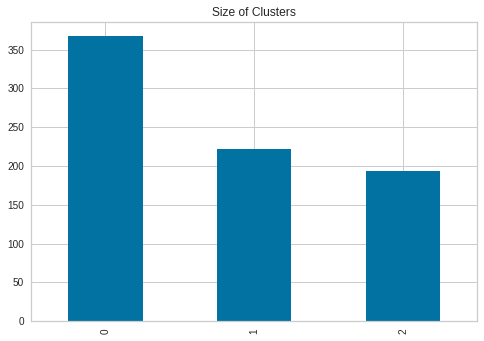

In [ ]:
cluster_df['cluster'].value_counts().plot.bar(x = 'cluster', y = '# records', title = 'Size of Clusters')

## Pairwise Mutual Information Analysis

PMI is a mathematical measure defined in the area of information theory that describes the "mutual information" between two random variables at a point of a joint distribution by producing a ratio that describes the relative independence of the random variables against their incidence across the entire corpus.

In [ ]:
word_freq = Counter(x for xs in df['tokens'] for x in set(xs))
word_freq = pd.DataFrame(word_freq.items(), columns = ['word','count'])
word_freq = word_freq.sort_values('count',ascending = False)
total = sum(word_freq['count'])
word_freq['Px'] = word_freq['count']/total

In [ ]:
clusters = list(set(cluster_df['cluster'].to_list()))
cluster_df1 = pd.merge(cluster_df, df, left_index=True, right_on = 'PMID')

cluster_idf = cluster_df1[cluster_df1['cluster']==2]

In [ ]:
word_freq1 = Counter(x for xs in cluster_idf['tokens'] for x in set(xs))
word_freq1 = pd.DataFrame(word_freq1.items(), columns = ['word','count'])
word_freq1 = word_freq1.sort_values('count',ascending = False)
word_freq1['Pxy'] = word_freq1['count']/total
cluster_idf['doc_len'] = len(cluster_idf['tokens'])
words_cluster = sum(cluster_idf['doc_len'])/total
PMI_table = pd.merge(word_freq, word_freq1,on = 'word')
PMI_table['Gold'] = PMI_table.apply(lambda row: math.log(row['Pxy']/(row['Px']*words_cluster)),axis=1)
PMI_table = PMI_table.sort_values('Gold',ascending = False)
words = [word for word in PMI_table['word'] if word.isalpha()]
PMI_table = PMI_table[PMI_table['word'].isin(words)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
PMI_table = PMI_table[~PMI_table['word'].isin(stopwords)]
PMI_table = PMI_table[PMI_table['count_x']>4]
PMI_table

,word,count_x,Px,count_y,Pxy,Gold
2595,insulin,5,0.000045,5,0.000045,1.082892
2134,moderately,7,0.000064,7,0.000064,1.082892
1889,sociodemographic,9,0.000082,8,0.000073,0.965109
2114,comparable,8,0.000073,7,0.000064,0.949360
2045,worked,8,0.000073,7,0.000064,0.949360
...,...,...,...,...,...,...
1059,options,20,0.000182,1,0.000009,-1.912841
901,communities,23,0.000209,1,0.000009,-2.052603
453,opportunity,46,0.000418,2,0.000018,-2.052603
855,feasible,24,0.000218,1,0.000009,-2.095162


## Word Clouds


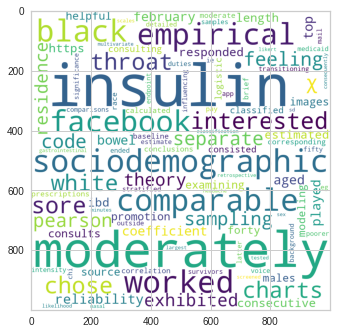

In [ ]:
wc_dict = pd.Series(PMI_table.Gold.values,index=PMI_table.word).to_dict()

wc = WordCloud(background_color="white",width=1000,height=1000, max_words=100, relative_scaling=0.5,normalize_plurals=True).generate_from_frequencies(wc_dict)
plt.imshow(wc)

In [ ]:
df_2 = cluster_idf[['PMID','Title','Abstract','text_body','tokens','u_tokens']]
df_2 = provide_features(df_2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f28fe8be4a8>,
                 k=None, metric=None, model=None, timings=True)

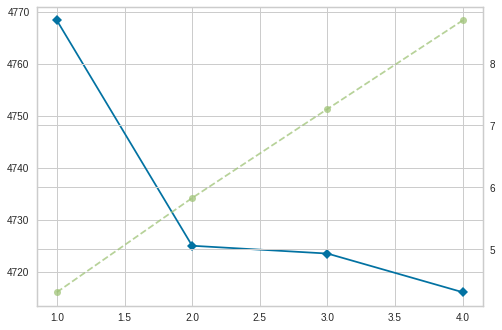

In [ ]:
features = df_2['tfidf'].to_list()
features = pd.DataFrame(features)
features = features.fillna(0)
features['PM ID'] = list(df_2['PMID'])
k_features = features.drop(['PM ID'],axis=1).to_numpy()

model = KModes()
visualizer = KElbowVisualizer(model, k=(1,5))
visualizer.fit(k_features)

In [ ]:
km = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(k_features)
features['cluster'] = clusters
cluster_df = features[['PM ID','cluster']]
cluster_df = cluster_df.set_index('PM ID')

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 76, cost: 31521.0
Run 1, iteration: 2/100, moves: 29, cost: 31494.0
Run 1, iteration: 3/100, moves: 6, cost: 31493.0
Run 1, iteration: 4/100, moves: 0, cost: 31493.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 81, cost: 31490.0
Run 2, iteration: 2/100, moves: 28, cost: 31474.0
Run 2, iteration: 3/100, moves: 12, cost: 31467.0
Run 2, iteration: 4/100, moves: 3, cost: 31467.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 74, cost: 31517.0
Run 3, iteration: 2/100, moves: 18, cost: 31499.0
Run 3, iteration: 3/100, moves: 22, cost: 31475.0
Run 3, iteration: 4/100, moves: 7, cost: 31471.0
Run 3, iteration: 5/100, moves: 1, cost: 31470.0
Run 3, iteration: 6/100, moves: 1, cost: 31470.0
Init: initializing centroids
Init: initializing clusters
Starting 

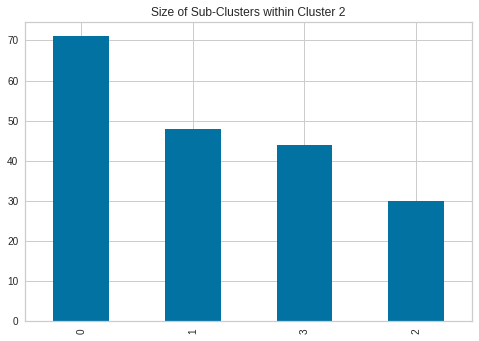

In [ ]:
features['cluster'] = clusters
cluster_df = features[['PM ID','cluster']]
cluster_df = cluster_df.set_index('PM ID')

cluster_df['cluster'].value_counts().plot.bar(x = 'cluster', y = '# records', title = 'Size of Sub-Clusters within Cluster 2')

In [ ]:
word_freq = Counter(x for xs in df_2['tokens'] for x in set(xs))
word_freq = pd.DataFrame(word_freq.items(), columns = ['word','count'])
word_freq = word_freq.sort_values('count',ascending = False)
total = sum(word_freq['count'])
word_freq['Px'] = word_freq['count']/total

In [ ]:
clusters = list(set(cluster_df['cluster'].to_list()))
cluster_df1 = pd.merge(cluster_df, df_2, left_index=True, right_on = 'PMID')

cluster_idf = cluster_df1[cluster_df1['cluster']==3]

In [ ]:
word_freq1 = Counter(x for xs in cluster_idf['tokens'] for x in set(xs))
word_freq1 = pd.DataFrame(word_freq1.items(), columns = ['word','count'])
word_freq1 = word_freq1.sort_values('count',ascending = False)
word_freq1['Pxy'] = word_freq1['count']/total
cluster_idf['doc_len'] = len(cluster_idf['tokens'])
words_cluster = sum(cluster_idf['doc_len'])/total
PMI_table = pd.merge(word_freq, word_freq1,on = 'word')
PMI_table['Gold'] = PMI_table.apply(lambda row: math.log(row['Pxy']/(row['Px']*words_cluster)),axis=1)
PMI_table = PMI_table.sort_values('Gold',ascending = False)
words = [word for word in PMI_table['word'] if word.isalpha()]
PMI_table = PMI_table[PMI_table['word'].isin(words)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
PMI_table = PMI_table[~PMI_table['word'].isin(stopwords)]
PMI_table = PMI_table[PMI_table['count_x']>4]
PMI_table

,word,count_x,Px,count_y,Pxy,Gold
1073,imposed,6,0.000177,5,0.000148,2.680174
1204,recovery,5,0.000148,4,0.000118,2.639352
1224,implementing,5,0.000148,4,0.000118,2.639352
897,neurological,7,0.000207,5,0.000148,2.526024
1045,agreed,6,0.000177,4,0.000118,2.457031
...,...,...,...,...,...,...
368,months,18,0.000531,1,0.000030,-0.027876
329,development,19,0.000561,1,0.000030,-0.081943
308,determine,21,0.000620,1,0.000030,-0.182026
287,evidence,23,0.000679,1,0.000030,-0.272998


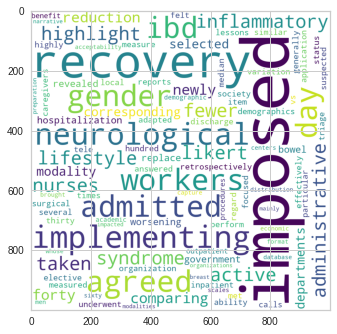

In [ ]:
wc_dict = pd.Series(PMI_table.Gold.values,index=PMI_table.word).to_dict()

wc = WordCloud(background_color="white",width=1000,height=1000, max_words=100, relative_scaling=0.5,normalize_plurals=True).generate_from_frequencies(wc_dict)
plt.imshow(wc)